In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [34]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

# 데이터셋 경로 설정
dataset_path = '/content/drive/MyDrive/atm'

# 이미지 읽어오기
images = []
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img = cv2.imread(os.path.join(dataset_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 색상 채널 변환
        img = cv2.resize(img, (128, 128))  # 이미지 크기 조정
        images.append(img)

# 이미지 데이터를 numpy 배열로 변환
images = np.array(images) / 255.0  # 0-1 범위로 정규화

# 훈련 및 검증 데이터셋 나누기
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)


In [35]:
from tensorflow.keras import layers, models

# 간단한 Autoencoder 모델 정의
input_img = layers.Input(shape=(128, 128, 3))

# 인코더
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# 디코더
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# 모델 생성
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [36]:
# 훈련 데이터에 랜덤 노이즈 추가
noisy_X_train = X_train + np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
noisy_X_train = np.clip(noisy_X_train, 0., 1.)  # 픽셀 값을 [0, 1]로 클리핑

# Autoencoder 학습
autoencoder.fit(noisy_X_train, X_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 0.0700 - val_loss: 0.0532
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0440 - val_loss: 0.0228
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - val_loss: 0.0141
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 13/50

In [37]:
# 훈련 데이터에서 SSIM 계산
train_ssim_scores = []
for img in X_train:
    reconstructed_img = autoencoder.predict(np.expand_dims(img, axis=0))
    ssim_score = calculate_ssim(img, reconstructed_img[0])
    train_ssim_scores.append(ssim_score)

# 평균과 표준편차 계산
mean_ssim = np.mean(train_ssim_scores)
std_ssim = np.std(train_ssim_scores)

# SSIM 임계값 설정 (평균 - 2*표준편차)
ssim_threshold = mean_ssim - 2 * std_ssim
print(f"SSIM Threshold: {ssim_threshold}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

Found 9 images for testing.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


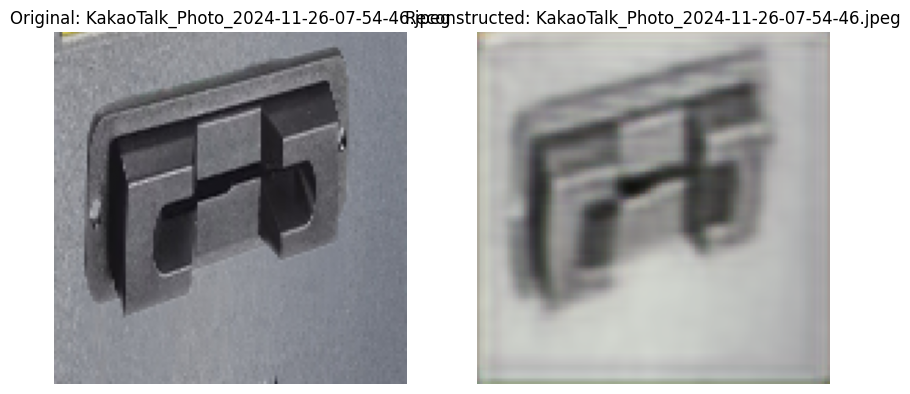

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


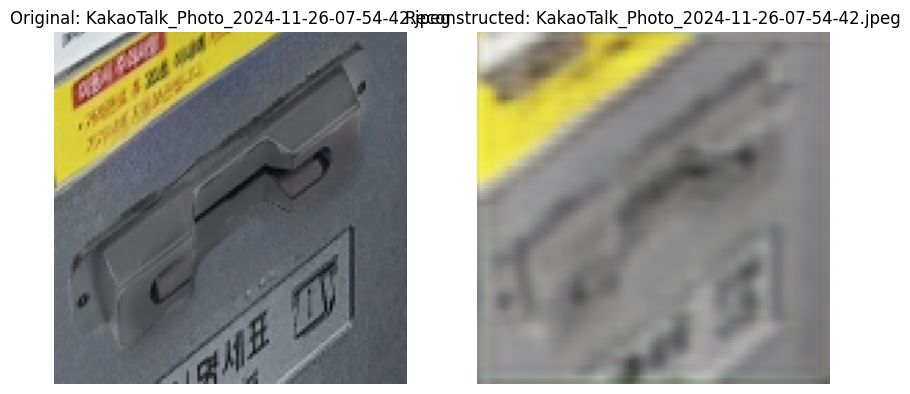

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


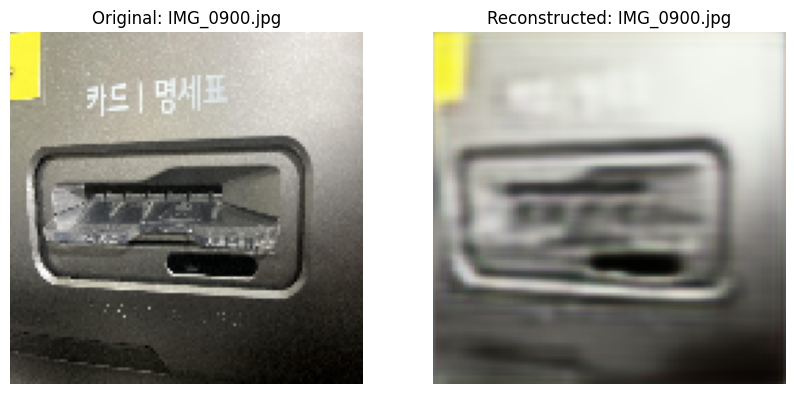

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


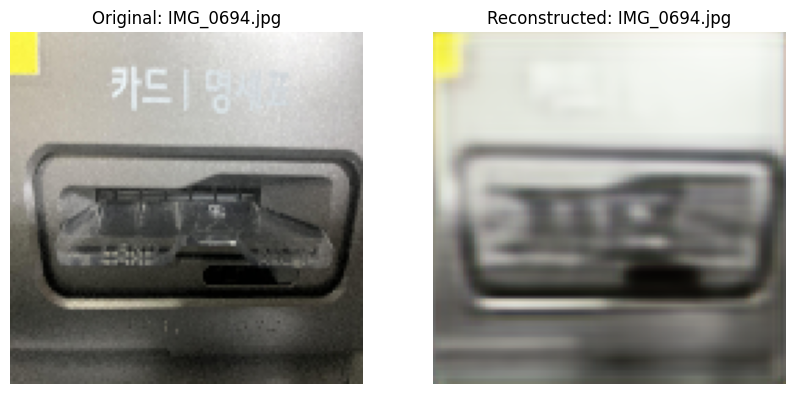

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


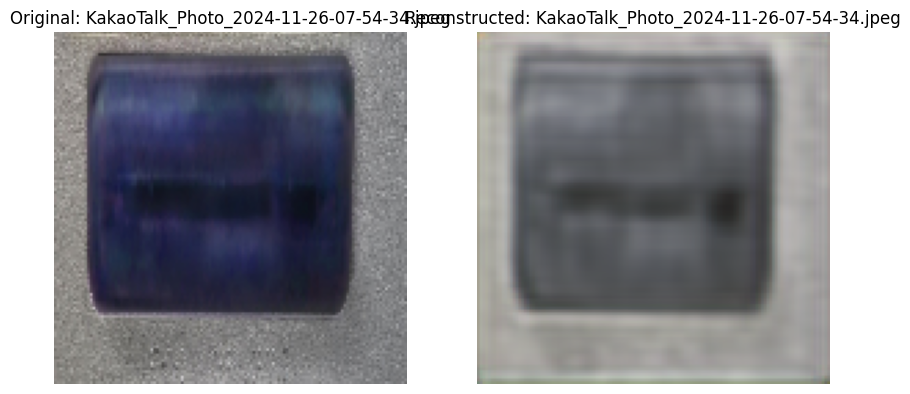

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


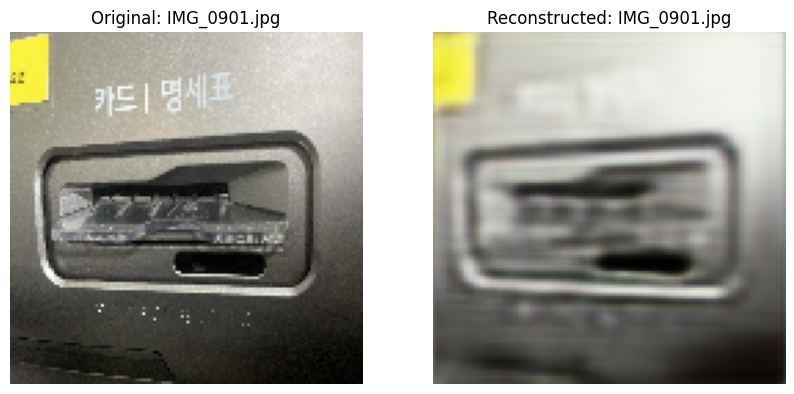

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


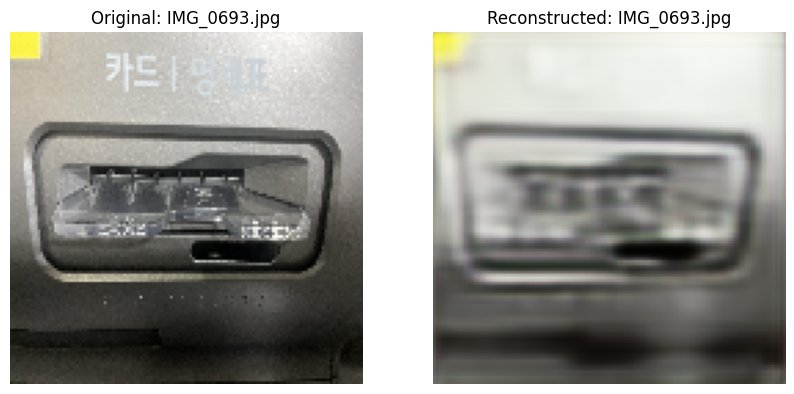

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


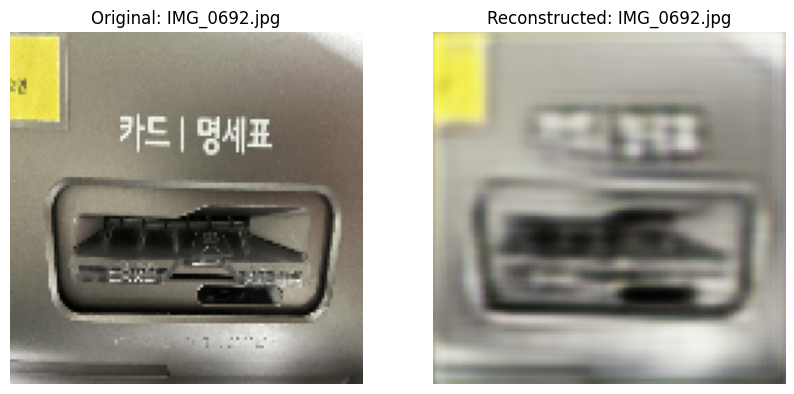

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


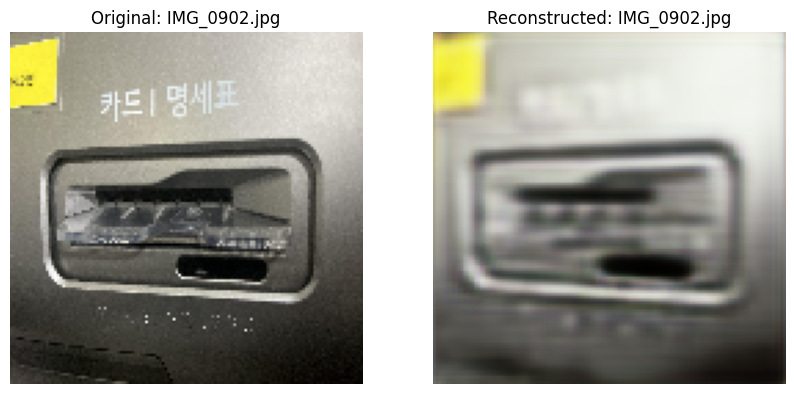

In [38]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 테스트 데이터 경로
test_dataset_path = '/content/test_dir'

# 이미지 파일 리스트 가져오기
test_images = [f for f in os.listdir(test_dataset_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
print(f"Found {len(test_images)} images for testing.")

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 색상 채널 변환
    img = cv2.resize(img, (128, 128))  # 모델에 맞는 크기로 조정
    img = np.array(img) / 255.0  # 0-1 범위로 정규화
    return img

# 테스트 이미지 처리
for test_image in test_images:
    image_path = os.path.join(test_dataset_path, test_image)

    # 이미지를 로드하고 전처리
    img = load_and_preprocess_image(image_path)
    img_batch = np.expand_dims(img, axis=0)  # 배치 차원 추가

    # 모델 예측 (복원된 이미지 계산)
    reconstructed_img = autoencoder.predict(img_batch)

    # 원본 이미지와 복원된 이미지 출력
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # 원본 이미지 출력
    axes[0].imshow(img)
    axes[0].set_title(f"Original: {test_image}")
    axes[0].axis('off')

    # 복원된 이미지 출력
    axes[1].imshow(reconstructed_img[0])  # 배치 차원 제거
    axes[1].set_title(f"Reconstructed: {test_image}")
    axes[1].axis('off')

    plt.show()


In [39]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os


# 훈련 데이터의 평균 재구성 오차와 표준편차를 구해서 임계값 설정
train_reconstruction_errors = []  # 훈련 중 재구성 오차 리스트

for img in X_train:
    reconstructed_img = autoencoder.predict(np.expand_dims(img, axis=0))
    error = np.mean(np.square(img - reconstructed_img[0]))  # MSE 계산
    train_reconstruction_errors.append(error)

# 평균과 표준편차 구하기
mean_error = np.mean(train_reconstruction_errors)
std_error = np.std(train_reconstruction_errors)

# 임계값을 평균 + 2*표준편차로 설정 (재구성 오차가 크게 나올 확률이 낮은 값)
threshold = mean_error + 2 * std_error

def calculate_ssim(original, reconstructed):
    original = (original * 255).astype("uint8")
    reconstructed = (reconstructed * 255).astype("uint8")
    # SSIM 계산 시 win_size=3으로 설정
    score, _ = ssim(original, reconstructed, multichannel=True, full=True, win_size=3)
    return score

for test_image in test_images:
    image_path = os.path.join(test_dataset_path, test_image)

    # 이미지 로드 및 전처리
    img = load_and_preprocess_image(image_path)
    img_batch = np.expand_dims(img, axis=0)  # 배치 차원 추가

    # 복원된 이미지 계산
    reconstructed_img = autoencoder.predict(img_batch)

    # 재구성 오차 (MSE) 계산
    reconstruction_error = calculate_reconstruction_error(img, reconstructed_img[0])

    # SSIM 계산
    ssim_score = calculate_ssim(img, reconstructed_img[0])

    # 이상 여부 판단
    if reconstruction_error > threshold or ssim_score < ssim_threshold:
        print(f"Image {test_image} is Anomalous.")
    else:
        print(f"Image {test_image} is Normal.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [32]:
# 모델 저장 경로
model_save_path = "/content/atm_autoencoder_model_final.h5"

# 모델 저장
autoencoder.save(model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at /content/atm_autoencoder_model_final.h5


In [33]:
from google.colab import files

# 모델 파일 다운로드
files.download(model_save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
!pip install pillow pyheif


In [21]:
import os
from PIL import Image
import pyheif

# HEIC 파일을 변환하는 함수
def convert_heic_to_png_or_jpeg(input_path, output_path, format="JPEG"):
    heif_file = pyheif.read(input_path)  # HEIC 파일 읽기
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
    )
    # 변환된 이미지를 저장
    image.save(output_path, format=format)
    print(f"Converted {input_path} to {output_path}")

# HEIC 파일이 저장된 폴더 경로
folder_path = "/content/test_dir"  # HEIC 파일이 있는 폴더 경로

# HEIC 파일 변환 및 삭제 루프
for file_name in os.listdir(folder_path):
    if file_name.endswith(".HEIC"):
        input_file = os.path.join(folder_path, file_name)
        output_file = os.path.join(folder_path, f"{os.path.splitext(file_name)[0]}.jpg")  # JPEG로 저장

        # HEIC -> JPEG 변환
        convert_heic_to_png_or_jpeg(input_file, output_file, format="JPEG")

        # 원본 HEIC 파일 삭제
        os.remove(input_file)
        print(f"Deleted original HEIC file: {input_file}")

print("All HEIC files converted and original files deleted.")


Converted /content/test_dir/IMG_0693.HEIC to /content/test_dir/IMG_0693.jpg
Deleted original HEIC file: /content/test_dir/IMG_0693.HEIC
Converted /content/test_dir/IMG_0692.HEIC to /content/test_dir/IMG_0692.jpg
Deleted original HEIC file: /content/test_dir/IMG_0692.HEIC
Converted /content/test_dir/IMG_0694.HEIC to /content/test_dir/IMG_0694.jpg
Deleted original HEIC file: /content/test_dir/IMG_0694.HEIC
Converted /content/test_dir/IMG_0900.HEIC to /content/test_dir/IMG_0900.jpg
Deleted original HEIC file: /content/test_dir/IMG_0900.HEIC
Converted /content/test_dir/IMG_0902.HEIC to /content/test_dir/IMG_0902.jpg
Deleted original HEIC file: /content/test_dir/IMG_0902.HEIC
Converted /content/test_dir/IMG_0901.HEIC to /content/test_dir/IMG_0901.jpg
Deleted original HEIC file: /content/test_dir/IMG_0901.HEIC
All HEIC files converted and original files deleted.


In [19]:
# 변환 후 폴더 내 파일 확인
converted_files = os.listdir(folder_path)
print("Remaining files in folder:", converted_files)


Remaining files in folder: ['KakaoTalk_Photo_2024-11-26-07-54-46.jpeg', 'KakaoTalk_Photo_2024-11-26-07-54-42.jpeg', 'IMG_0693.HEIC', 'IMG_0692.HEIC', 'IMG_0694.HEIC', 'KakaoTalk_Photo_2024-11-26-07-54-34.jpeg', 'IMG_0900.HEIC', 'IMG_0902.HEIC', 'IMG_0901.HEIC']


In [20]:
import os

folder_path = "/content/test_dir"

# 폴더의 파일 리스트 출력
files = os.listdir(folder_path)
print("Files in the folder:", files)

# HEIC 파일만 출력
heic_files = [file for file in files if file.endswith(".heic")]
print("HEIC files:", heic_files)


Files in the folder: ['KakaoTalk_Photo_2024-11-26-07-54-46.jpeg', 'KakaoTalk_Photo_2024-11-26-07-54-42.jpeg', 'IMG_0693.HEIC', 'IMG_0692.HEIC', 'IMG_0694.HEIC', 'KakaoTalk_Photo_2024-11-26-07-54-34.jpeg', 'IMG_0900.HEIC', 'IMG_0902.HEIC', 'IMG_0901.HEIC']
HEIC files: []
